In [9]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import itertools

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [2]:
# 경로 설정
path = '../data/ml-latest-small/'

# 해당 path file 확인
os.listdir(path)

['links.csv', 'movies.csv', 'ratings.csv', 'README.txt', 'tags.csv']

In [3]:
ratings_df = pd.read_csv(os.path.join(path + 'ratings.csv'), encoding='utf-8')
tags_df = pd.read_csv(os.path.join(path + 'tags.csv'), encoding='utf-8')
movies_df = pd.read_csv(os.path.join(path + 'movies.csv'), index_col='movieId', encoding='utf-8')

### 장르 분석

In [5]:
movies_df.head(3)

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance


In [8]:
all_genres = [x.split('|') for x in movies_df['genres'].values]

In [20]:
genres = list(set(itertools.chain(*all_genres)))

print(len(all_genres), len(genres))

9742 20


In [38]:
genres_df = movies_df['genres'].str.get_dummies(sep='|')
genres_df.head(3)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [39]:
movies_df = pd.concat([movies_df, genres_df], axis = 1)
movies_df.head(3)

,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


#### 특정 장르의 평점과 user 분석

In [40]:
movies_df.columns

Index(['title', 'genres', '(no genres listed)', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [51]:
movie_list = movies_df['title'][movies_df.Animation == 1]

animation_df = ratings_df[ratings_df['movieId'].isin(movie_list.index)]

animation_df.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
35,1,596,5.0,964982838
38,1,661,5.0,964982838


In [58]:
# user별 animation 장르 평점 평균
animation_df.groupby('userId')['rating'].mean()

userId
1      4.689655
3      0.500000
4      4.000000
5      4.333333
6      4.071429
         ...   
606    3.714286
607    3.333333
608    3.118182
609    3.000000
610    3.901515
Name: rating, Length: 527, dtype: float64

#### 장르간 상관관계

<AxesSubplot:>

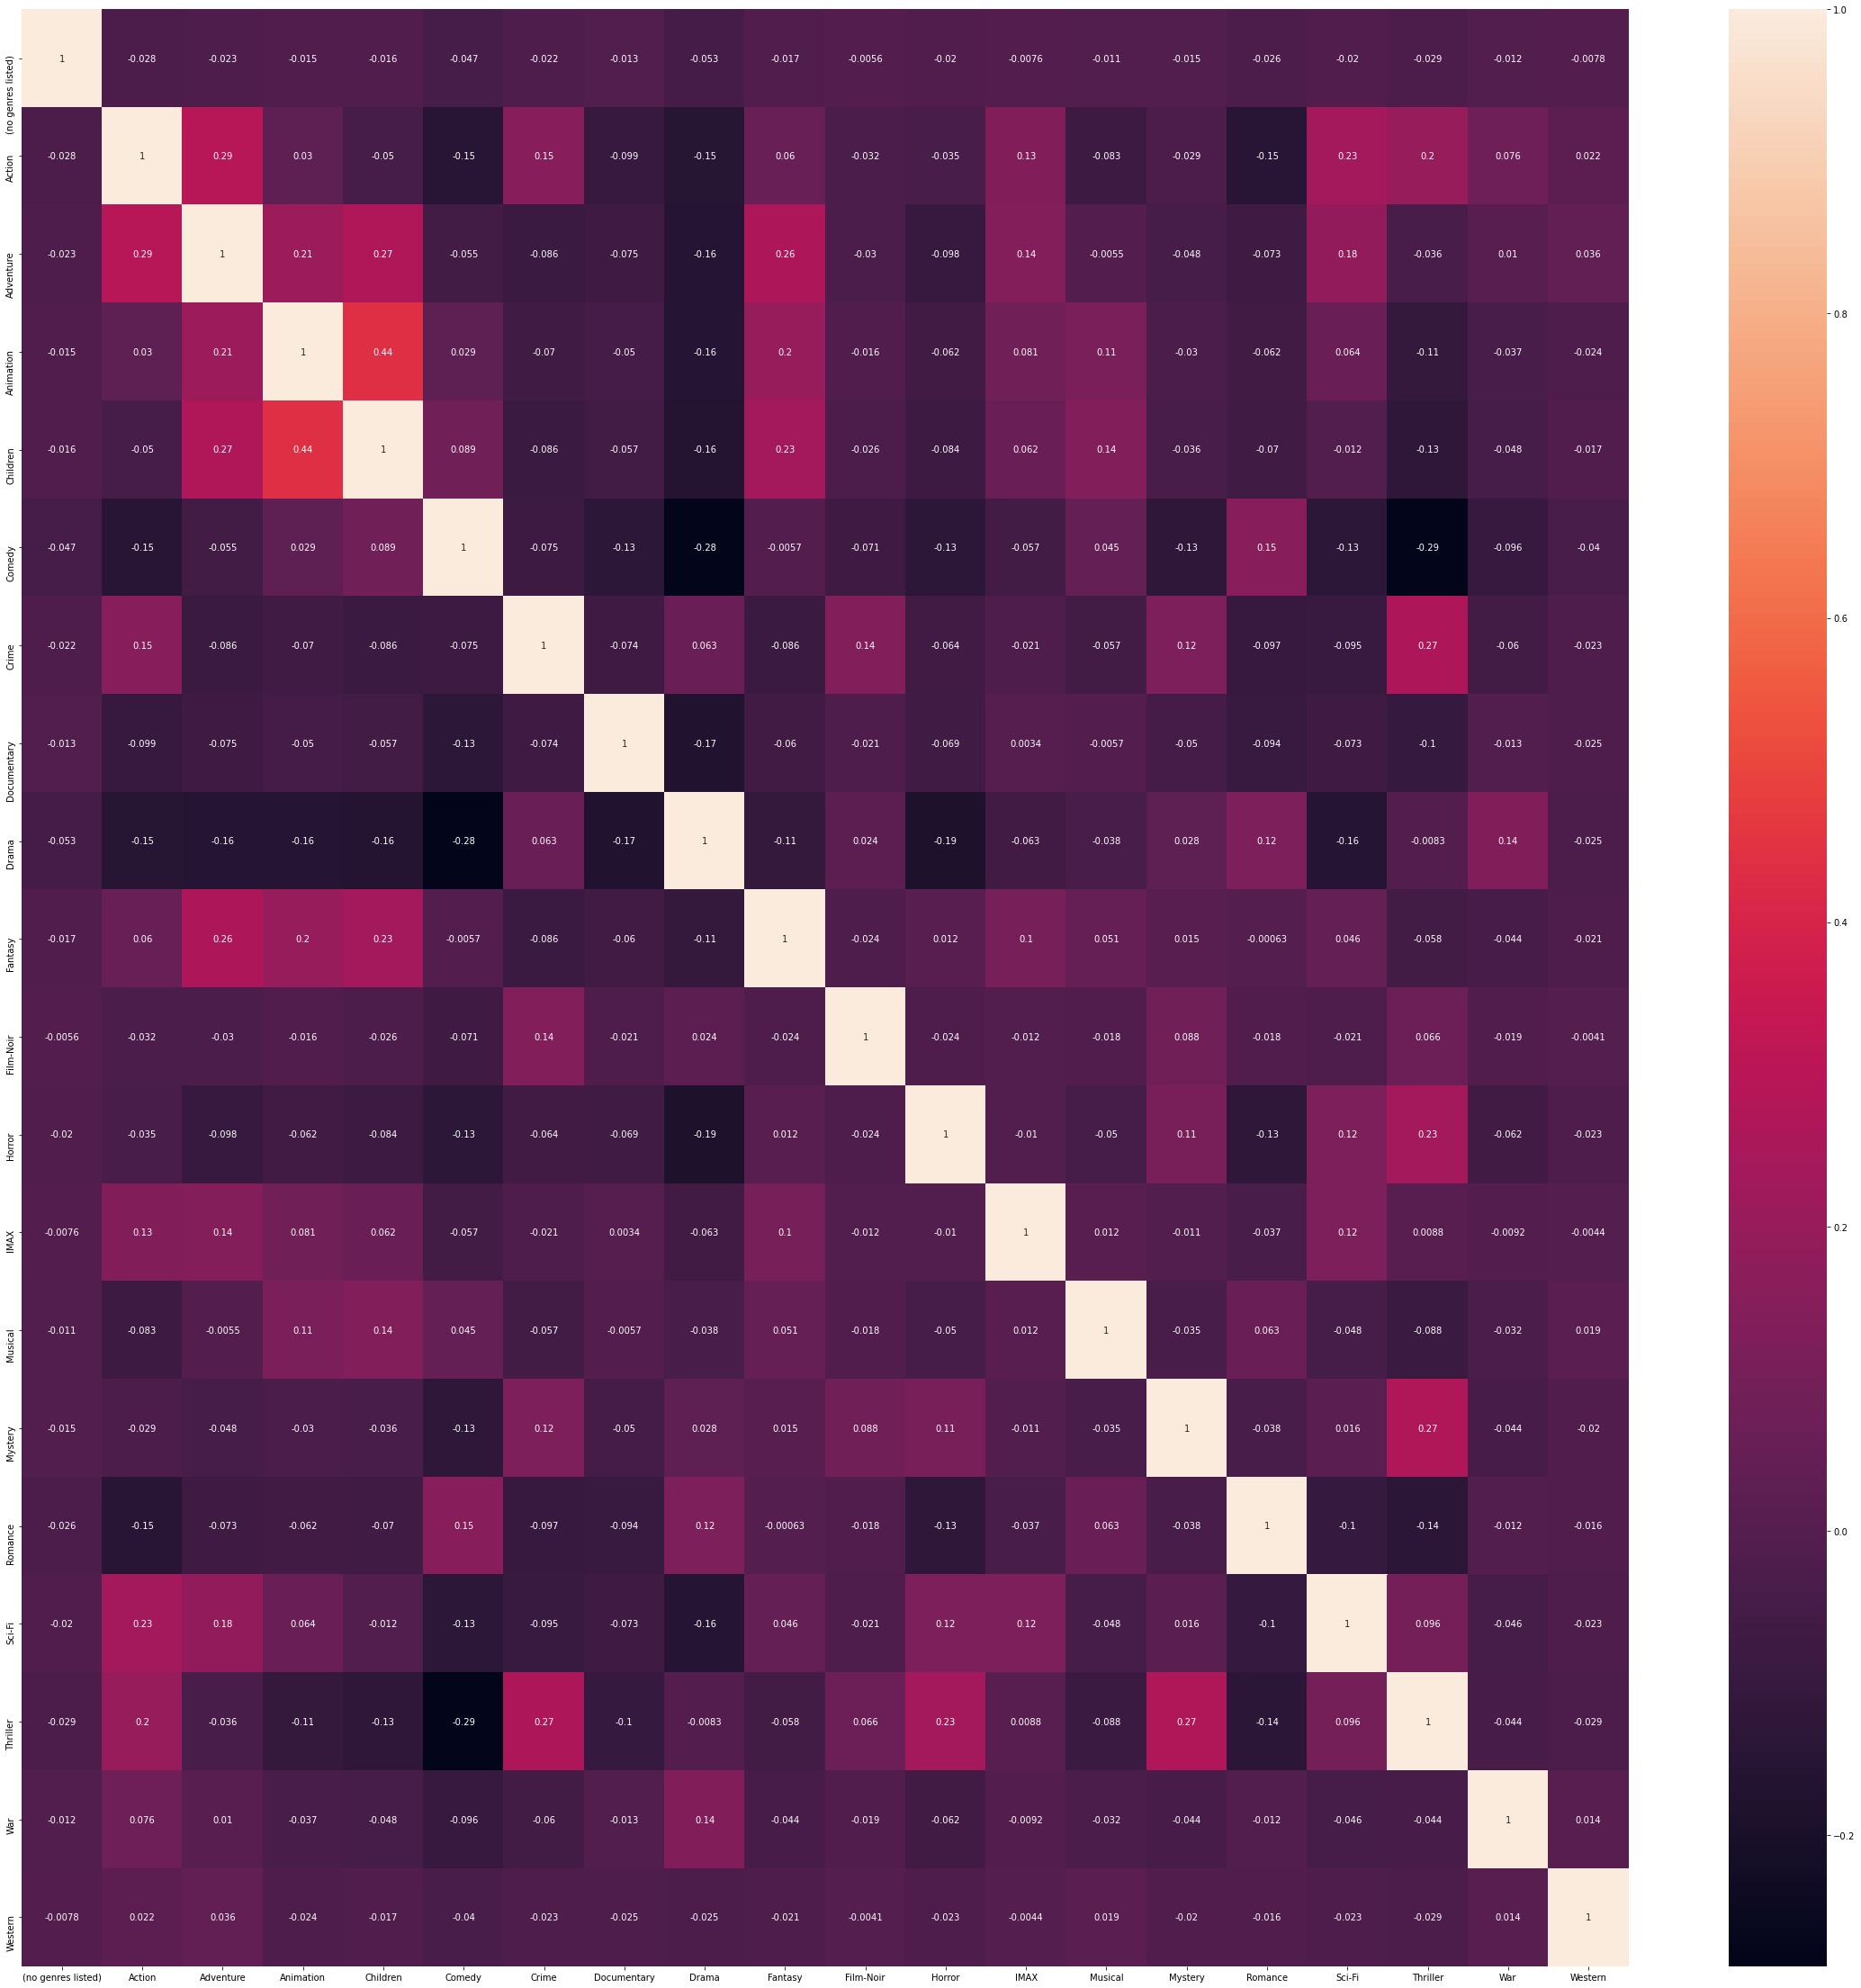

In [64]:
# genres_df.corr()

plt.figure(figsize = (40,40))
sns.heatmap(genres_df.corr(), annot = True) # annot : 값 표시

#### 영화 이름, 연도 분석

In [71]:
import re

In [133]:
title_df = movies_df[['title', 'genres']]

check_year = re.compile('\(\d\d\d\d\)')

# title_df['year'] = title_df['title'].apply(lambda x : check_year.search(x).group() if check_year.search(x) else '')
title_df['year'] = title_df['title'].str.extract('(\(\d\d\d\d\))')

title_df.isna().sum()

title      0
genres     0
year      13
dtype: int64

In [137]:
title_df[title_df['year'].isnull()]

title_df.dropna(axis=0, inplace=True)

In [140]:
title_df['year'] = title_df['year'].apply(lambda x: x.replace('(','').replace(')',''))

title_df.head(3)

,title,genres,year
movieId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
2,Jumanji (1995),Adventure|Children|Fantasy,1995
3,Grumpier Old Men (1995),Comedy|Romance,1995


#### 연도별 영화 데이터 분석

In [143]:
year_freq_df = title_df.groupby('year')['title'].count()
year_freq_df.head(3)

year
1902    1
1903    1
1908    1
Name: title, dtype: int64

In [145]:
year_freq_df.sort_values(ascending=False).describe()

count    106.000000
mean      91.783019
std      102.227757
min        1.000000
25%       16.000000
50%       39.500000
75%      151.500000
max      311.000000
Name: title, dtype: float64

#### 영화와 개봉연도 그리고 평점

In [169]:
# 2000에 개봉한 영화에 대한 평점 평균
round(ratings_df['rating'][ratings_df['movieId'].isin(title_df[title_df['year'] == '2000'].index)].mean(),3)

3.399

In [176]:
results = []
for year in title_df['year'].unique():
    avg_ratings = ratings_df['rating'][ratings_df['movieId'].isin(title_df[title_df['year'] == str(year)].index)].mean()
    results.append((year, round(avg_ratings, 3)))

result_df = pd.DataFrame(results, columns=['year','avg_ratings'])
result_df.sort_values(by='year')

,year,avg_ratings
91,1902,3.500
92,1903,2.500
105,1908,4.000
84,1915,2.000
87,1916,3.600
...,...,...
100,2014,3.513
101,2015,3.410
102,2016,3.387
103,2017,3.578


array([[<AxesSubplot:title={'center':'avg_ratings'}>]], dtype=object)

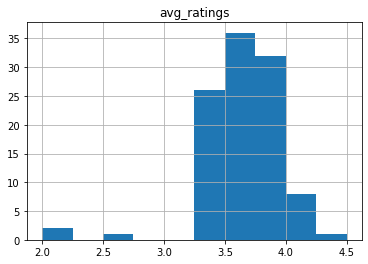

In [177]:
result_df.hist()